# Example workflow for H&E images

In [3]:
from pathml.core import SlideData, types

**a. Load the image**

The image used in this example is publicly avilalable for download: http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/

SlideData(name='example',
	slide_type=SlideType(stain=HE, platform=None, tma=None, rgb=True, volumetric=None, time_series=None),
	filepath='../../data/CMU-1.svs',
	backend='openslide',
	image shape: (32914, 46000),
	0 tiles: [],
	0 masks: [],
	labels=None,
	counts=None)


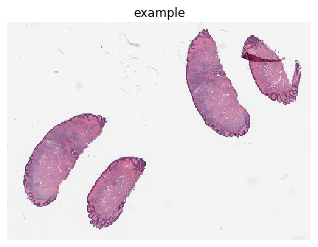

In [4]:
# load the image
wsi = SlideData("../../data/CMU-1.svs", name = "example", slide_type = types.HE)

# view basic information about the SlideData object
print(wsi)

# view a thumbnail of the whole slide image
wsi.plot()

**b. Define a preprocessing pipeline**

Pipelines are created by composing a sequence of modular transformations

In [5]:
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

pipeline = Pipeline([
    BoxBlur(kernel_size=15),
    TissueDetectionHE(mask_name = "tissue", min_region_size=500, 
                      threshold=30, outer_contours_only=True)
])

**c. Run preprocessing**

Now that we have constructed our pipeline, we are ready to run it on our WSI.
PathML supports distributed computing, speeding up processing by running tiles in parallel among many workers rather than processing each tile sequentially on a single worker. 
This is supported by [Dask.distributed](https://distributed.dask.org/en/latest/index.html) on the backend, and is highly scalable for very large datasets. 

The first step is to create a `Client` object. In this case, we will use a simple cluster running locally; however, Dask supports other set-ups including Kubernetes, SLURM, etc. See the [PathML documentation](https://pathml.readthedocs.io/en/latest/running_pipelines.html#distributed-processing) for more information.

In [6]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=6)
client = Client(cluster)

wsi.run(pipeline, distributed=True, client=client);

In [7]:
print(f"Total number of tiles extracted: {len(wsi.tiles)}")

Total number of tiles extracted: 150


**e. Save results to disk**

The resulting preprocessed data is written to disk, leveraging the HDF5 data specification optimized for efficiently manipulating larger-than-memory data.

In [8]:
wsi.write("./data/CMU-1-preprocessed.h5path")

**f. Create PyTorch DataLoader**

The `DataLoader` provides an interface with any machine learning model built on the PyTorch ecosystem

In [9]:
from pathml.ml import TileDataset
from torch.utils.data import DataLoader

dataset = TileDataset("./data/CMU-1-preprocessed.h5path")
dataloader = DataLoader(dataset, batch_size = 16, num_workers = 4)